In [42]:
from src import preprocessor
from src import load_qwen_model
from src import decoder

from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
import torch

# Initial Performance

In [2]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
model, tokeniser, device = load_qwen_model(model_name)

Currently loading: Qwen/Qwen2.5-0.5B-Instruct


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Model loaded on mps


In [3]:
train_set, validation_set, test_set = preprocessor('lotka_volterra_data.h5', percentile= 90, decimal_places=3,  train_fraction =0.7, validation_fraction= 0.15 , shuffle = False, tokeniser_model = tokeniser)

INFO - File loaded successfully. Trajectories shape: (1000, 100, 2), Time points shape: (100,)
INFO - Scaling data by alpha=0.25283724069595337, ensuring 90% of values fit within the model's expected range.
INFO - Data scaled to 3 decimal places
INFO - An example of the data encoding is shown below:
Before Encoding - First 5 Prey Data: ['3.757', '2.929', '2.698', '2.835', '3.261']
Before Encoding - First 5 Predator Data: ['4.116', '3.083', '2.232', '1.612', '1.188']
After Encoding to String - First 5 Entries: 3.757,4.116;2.929,3.083;2.698,2.232;2.835,1.612;3.261,1.188
After Encoding to Tokenised: [18, 13, 22, 20, 22, 11, 19, 13, 16, 16, 21, 26, 17, 13, 24, 17, 24, 11, 18, 13, 15, 23, 18, 26, 17, 13, 21, 24, 23, 11, 17, 13, 17, 18, 17, 26, 17, 13, 23, 18, 20, 11, 16, 13, 21, 16, 17, 26, 18, 13, 17, 21, 16, 11, 16, 13, 16, 23, 23]


In [4]:
def plotting_trend(prey_original, prey_generated, predator_original, predator_generated, sequence_no, inference_split):

    # Create timesteps based on array length

    plt.figure(figsize=(10, 6))

    # Plot Prey Original
    plt.plot(range(len(prey_original)) , prey_original, 'bo-', label="True Prey Population")
    # Plot Prey Predicted
    plt.plot(range(len(prey_generated)) , prey_generated, 'rx-', label="Predicted Prey Population")
    # Plot Predator Original
    plt.plot(range(len(predator_original)), predator_original, 'go-', label="True Predator Population", alpha=0.5)
    # Plot Predator Predicted
    plt.plot(range(len(predator_generated)), predator_generated, 'g*-', label="Predicted Predator Population")
    # Mark start of generation
    plt.axvline(inference_split*len(prey_original), color='r', linestyle='--', label="Start of Inference")

    plt.xlabel("Timestep")
    plt.ylabel("Scaled popultation")
    plt.title(f"Prey Original vs. Prey Original with Predicted for System {sequence_no} with {inference_split} split")

    plt.grid(True)
    plt.legend()
    plt.show()

In [55]:
def run_untrained_Model(model, tokeniser, dataset, sequence_no = 0, inference_split = 0.8, plot = False, randomness = False, print_output = False):
    
    model.eval()
    sequence = dataset[sequence_no]
    tokenised_input = tokeniser(sequence, return_tensors="pt")
    tokenised_sequence = tokenised_input.input_ids.to(model.device)
    attention_mask = tokenised_input.attention_mask.to(model.device)

    split_indx = int(inference_split * tokenised_sequence.shape[1])
    input_tokens = tokenised_sequence[:, :split_indx]
    input_attention_mask = attention_mask[:, :split_indx]

    with torch.no_grad():
        # we need to account for the fact that in our scaling algorithm we scaled between 90% being between 0-10
        # this means some values above this have an extra figure and thus slightly more tokens are needed
        if print_output == True:
            print(f'Generating {1.2*(len(tokenised_input[0]) - split_indx)} tokens from a context of {len(input_tokens[0])} tokens')
        if print_output and randomness == True:
            print("Using a stochastic sampling technique, randomness is enabled")
        if print_output and randomness == False:
            print("Using a deterministic (greedy) sampling technique, randomness is disabled")
        output = model.generate(input_tokens, max_new_tokens = 1.2*(len(tokenised_input[0]) - split_indx),  attention_mask=input_attention_mask, do_sample=randomness)

    generated_qwen_text = tokeniser.decode(output[0], skip_special_tokens=True)
    prey_generated, predator_generated = decoder(generated_qwen_text)
    prey_original, predator_original = decoder(sequence)


    prey_generated = prey_generated[:len(prey_original)]
    predator_generated = predator_generated[:len(predator_original)]

    if plot == True:
        plotting_trend(prey_original, prey_generated, predator_original, predator_generated, sequence_no, inference_split)

    return  prey_original, predator_original, prey_generated, predator_generated

Generating 294.0 tokens from a context of 976 tokens
Using a deterministic (greedy) sampling technique, randomness is disabled


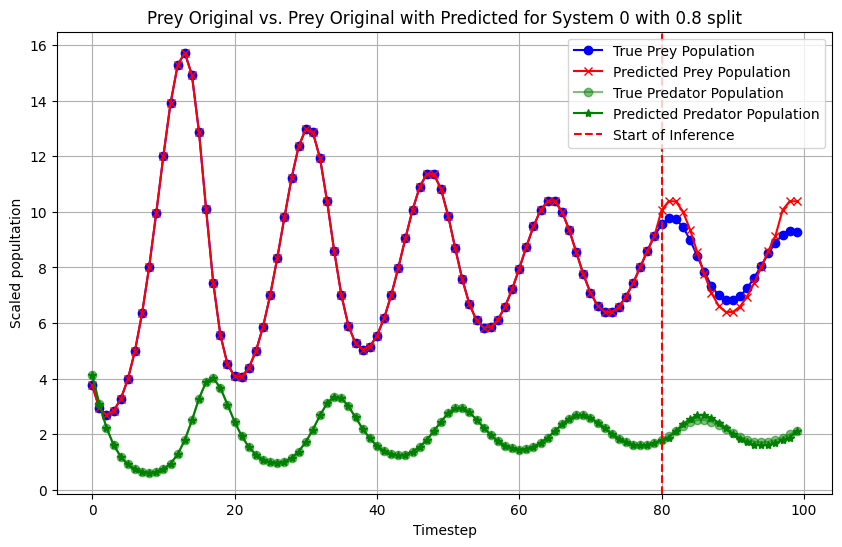

In [57]:
prey_original, predator_original, prey_generated, predator_generated = run_untrained_Model(model, tokeniser, train_set, sequence_no = 0, inference_split = 0.8, plot = True, randomness = False, print_output = True)

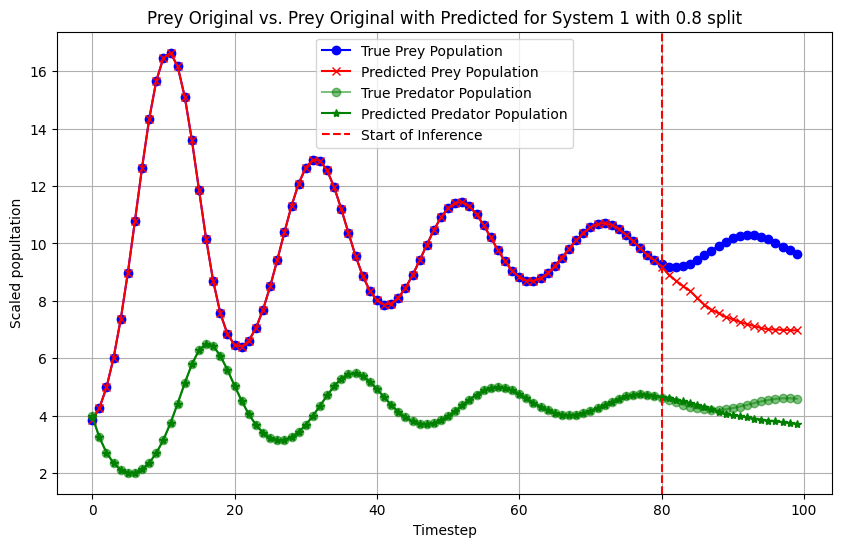

In [21]:
prey_original, predator_original, prey_generated, predator_generated = run_untrained_Model(model, tokeniser, train_set, sequence_no = 1, inference_split = 0.8, plot = True, randomness = False, print_output = True)

/Users/jacobtutt/.pyenv/versions/3.10.9/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/Users/jacobtutt/.pyenv/versions/3.10.9/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/Users/jacobtutt/.pyenv/versions/3.10.9/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:651: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


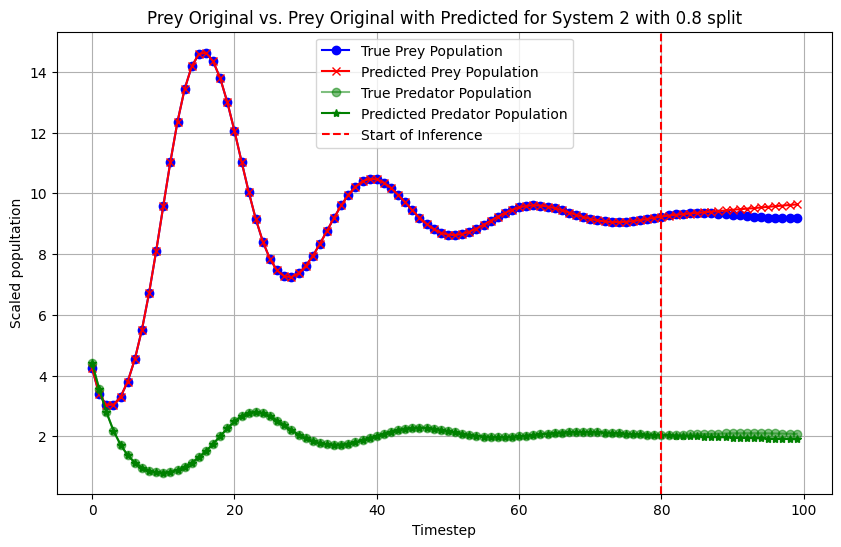

In [8]:
prey_original, predator_original, prey_generated, predator_generated = run_untrained_Model(model, tokeniser, train_set, sequence_no = 2, inference_split = 0.8, plot = True, randomness = False, print_output = True)

##  Analysis of the initial preformance
- This analysis gives the MSE and MAE for over a give number of random tests as a function of time step.

In [39]:
def model_analysis(no_random_samples, tokeniser, dataset, inference_split=0.8, plot=False, randomness=False):
    """
    Evaluates prediction error for a model on time series data by computing MAE and MSE.

    This function compares the model's generated predictions against ground truth data over
    the final portion of each sequence (as determined by `inference_split`). It returns
    per-timestep mean absolute error (MAE) and mean squared error (MSE) for both prey and predator values.

    Parameters
    ----------
    no_random_samples : int
        Number of sequences to evaluate (sampled from the dataset).
    tokeniser : PreTrainedTokenizer
        The tokenizer used for preparing model inputs.
    dataset : Dataset
        A dataset object containing sequences in string form.
    inference_split : float, optional
        Fraction of each sequence to use as input. The rest will be predicted (default is 0.8).
    plot : bool, optional
        (Unused here but passed to run_untrained_Model) Whether to show individual sequence plots.
    randomness : bool, optional
        Whether to sample greadily or softmax (e.g., `do_sample=True`) when generating predictions.

    Returns
    -------
    Tuple of four np.ndarrays:
        - MAE for prey (length = prediction window)
        - MAE for predator (length = prediction window)
        - MSE for prey (length = prediction window)
        - MSE for predator (length = prediction window)
    """

    # Determine how many timesteps are being predicted (after inference split)
    prediction_point = round((1 - inference_split) * 100)
    print(f"Prediction horizon: {prediction_point} timesteps")

    # Lists to collect true and generated data for each sample
    prey_original = []
    predator_original = []
    prey_generated = []
    predator_generated = []

    # Loop through a set number of random sequences from the dataset
    for i in range(no_random_samples):
        # Get model predictions and ground truth for this sequence
        prey_orig, predator_orig, prey_gen, predator_gen = run_untrained_Model(
            model,
            tokeniser,
            dataset,
            sequence_no=i,
            inference_split=inference_split,
            plot=plot,
            randomness=randomness
        )

        # Store only the predicted portion (last N timesteps)
        prey_original.append(prey_orig[-prediction_point:])
        predator_original.append(predator_orig[-prediction_point:])
        prey_generated.append(prey_gen[-prediction_point:])
        predator_generated.append(predator_gen[-prediction_point:])

    # Convert to NumPy arrays for element-wise operations
    error_prey = np.array(prey_original) - np.array(prey_generated)
    error_predator = np.array(predator_original) - np.array(predator_generated)

    # Compute Mean Absolute Error (MAE) per timestep, averaged over all sequences
    average_mean_abs_error_prey = np.mean(np.abs(error_prey), axis=0)
    average_mean_abs_error_predator = np.mean(np.abs(error_predator), axis=0)

    # Compute Mean Squared Error (MSE) per timestep, averaged over all sequences
    average_mean_squared_error_prey = np.mean(error_prey**2, axis=0)
    average_mean_squared_error_predator = np.mean(error_predator**2, axis=0)

    return (average_mean_abs_error_prey, average_mean_abs_error_predator,
        average_mean_squared_error_prey, average_mean_squared_error_predator)

In [43]:
def plot_model_errors_from_tuple(
    error_tuple,
    title_prefix="Model Prediction Errors"
):
    """
    Plots MAE and MSE for prey and predator using a tuple of error arrays.

    Parameters
    ----------
    error_tuple : Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]
        A tuple containing:
            - MAE for prey
            - MAE for predator
            - MSE for prey
            - MSE for predator
    title_prefix : str, optional
        Title prefix used for both plots.
    """
    mae_prey, mae_predator, mse_prey, mse_predator = error_tuple
    timesteps = np.arange(len(mae_prey))

    # ---- MAE Plot ----
    plt.figure(figsize=(10, 5))
    plt.plot(timesteps, mae_prey, label="Prey MAE", marker="o", color="blue")
    plt.plot(timesteps, mae_predator, label="Predator MAE", marker="x", color="green")
    plt.title(f"{title_prefix} - MAE")
    plt.xlabel("Timestep")
    plt.ylabel("Mean Absolute Error")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- MSE Plot ----
    plt.figure(figsize=(10, 5))
    plt.plot(timesteps, mse_prey, label="Prey MSE", marker="o", color="red")
    plt.plot(timesteps, mse_predator, label="Predator MSE", marker="x", color="purple")
    plt.title(f"{title_prefix} - MSE")
    plt.xlabel("Timestep")
    plt.ylabel("Mean Squared Error")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [32]:
_ , validation_set = preprocessor('lotka_volterra_data.h5', percentile= 90, decimal_places=3,split_fraction = 0.8, shuffle = True, tokeniser_model=tokeniser)

INFO - File loaded successfully. Trajectories shape: (1000, 100, 2), Time points shape: (100,)
INFO - Scaling data by alpha=0.25283724069595337, ensuring 90% of values fit within the model's expected range.
INFO - Data scaled to 3 decimal places
INFO - An example of the data encoding is shown below:
Before Encoding - First 5 Prey Data: ['3.757', '2.929', '2.698', '2.835', '3.261']
Before Encoding - First 5 Predator Data: ['4.116', '3.083', '2.232', '1.612', '1.188']
After Encoding to String - First 5 Entries: 3.536,3.630;3.216,3.517;2.960,3.351;2.777,3.146;2.666,2.925
After Encoding to Tokenised: [18, 13, 20, 18, 21, 11, 18, 13, 21, 18, 15, 26, 18, 13, 17, 16, 21, 11, 18, 13, 20, 16, 22, 26, 17, 13, 24, 21, 15, 11, 18, 13, 18, 20, 16, 26, 17, 13, 22, 22, 22, 11, 18, 13, 16, 19, 21, 26, 17, 13, 21, 21, 21, 11, 17, 13, 24, 17, 20]


# Analysis of Greedy/ Beam Search Generation Performance

In [45]:
greedy_errors = model_analysis(10, tokeniser, validation_set, inference_split = 0.8, plot = False, randomness = False)

Prediction horizon: 20 timesteps


/Users/jacobtutt/.pyenv/versions/3.10.9/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/Users/jacobtutt/.pyenv/versions/3.10.9/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/Users/jacobtutt/.pyenv/versions/3.10.9/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:651: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


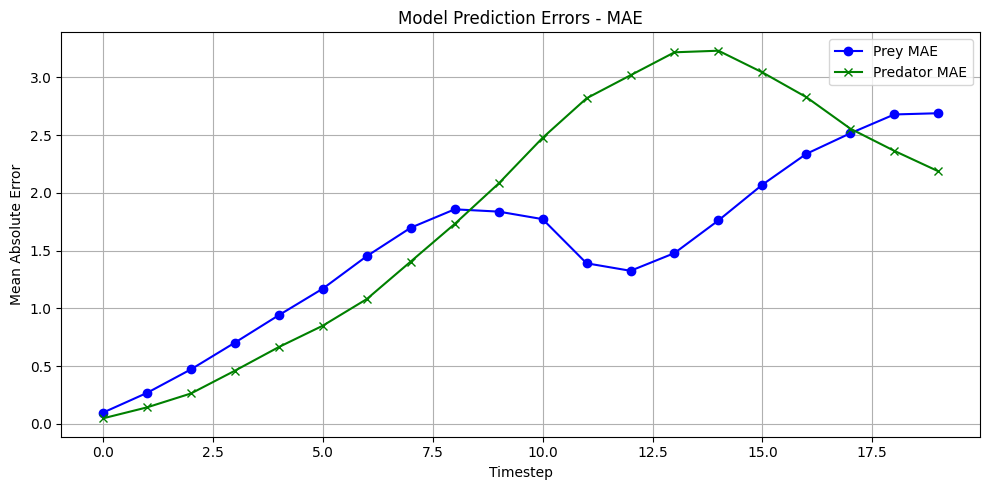

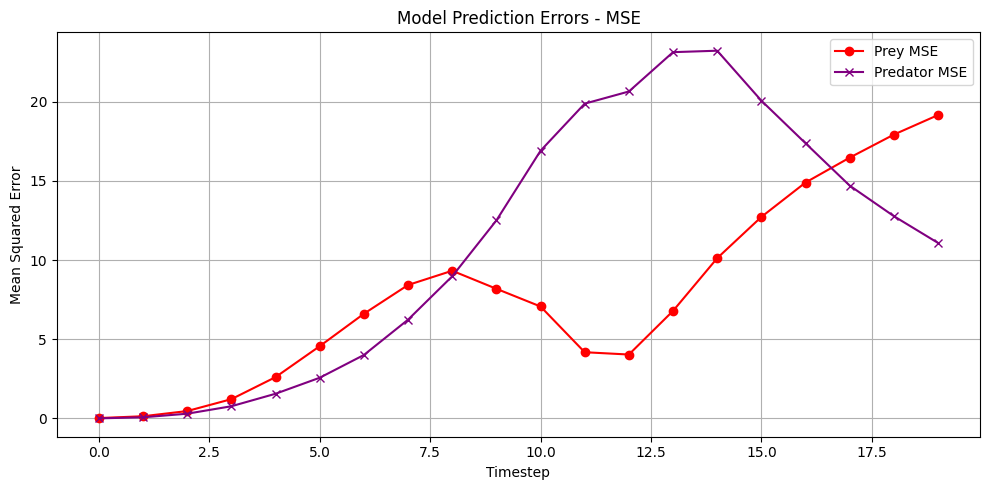

In [46]:
plot_model_errors_from_tuple(greedy_errors, title_prefix="Model Prediction Errors")

# Analysis of Stochastic Generation Performance

In [34]:
stochastic_errors = model_analysis(10, tokeniser, validation_set, inference_split = 0.8, plot = False, randomness = True)

20
0
1


(array([[10.556, 10.378,  9.603,  8.442,  7.236,  6.277,  5.705,  5.528,
          5.704,  6.183,  6.916,  7.828,  8.799,  9.658, 10.198, 10.247,
          9.74 ,  8.797,  7.689,  6.707],
        [ 4.337,  2.775,  1.905,  1.474,  1.289,  1.252,  1.321,  1.486,
          1.752,  2.132,  2.652,  3.34 ,  4.223,  5.319,  6.619,  8.048,
          9.42 , 10.379, 10.383,  8.991]], dtype=float32),
 array([[3.562, 4.129, 4.67 , 5.02 , 5.053, 4.769, 4.288, 3.763, 3.301,
         2.958, 2.754, 2.695, 2.785, 3.026, 3.412, 3.904, 4.417, 4.811,
         4.955, 4.802],
        [4.169, 3.922, 3.331, 2.674, 2.09 , 1.618, 1.255, 0.984, 0.786,
         0.647, 0.554, 0.5  , 0.481, 0.5  , 0.568, 0.711, 0.976, 1.44 ,
         2.19 , 3.201]], dtype=float32),
 array([[10.933, 10.625,  9.643,  7.917,  6.734,  5.728,  5.448,  5.292,
          5.   ,  4.91 ,  4.984,  5.265,  5.718,  6.221,  6.802,  7.358,
          8.001,  8.947,  9.947, 10.744],
        [ 4.244,  2.76 ,  1.872,  1.475,  1.147,  1.018,  0.99 ,  